In [3]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import linregress
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import json

import psycopg2
import pandas as pd

import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../..')
from carl import utils_carl
from carl.utils_carl import train_pred_xgboost, getStatValues,density_plot, get_mdfps,density_plot_multiple,train_pred_xgboost_2d
from functools import reduce
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
import warnings
#disable futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
df =  pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/Current_set_2980_all_features_vp_in_log10_Pa.csv')
import pickle
with open('/localhome/cschiebroek/MDFPs/mdfptools/carl/Experiments_result_analysis/molregno_to_molblock_2D.pickle', 'rb') as handle:
    molregno_to_molblock_2d = pickle.load(handle)
df['molblock'] = df['molregno'].apply(lambda x: molregno_to_molblock_2d[x])

In [5]:
molblocks = df['molblock'].tolist()
mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
mols = [Chem.AddHs(Chem.MolFromSmiles(Chem.MolToSmiles(mol))) for mol in mols]

In [6]:
from serenityff.charge.tree.dash_tree import DASHTree
tree = DASHTree(tree_folder_path="/localhome/cschiebroek/other/props")

Loading DASH tree data


DASHprop features:
1. Min/max/std partial charge
2. Counts: N atom < -0.5, > 0.5
3. HOMO LUMO (mean)

In [7]:
Dash_prop_dict = [tree.get_DASH_feature_dict_for_mol(mol) for mol in mols]

In [8]:
#add these to the dataframe
for key in Dash_prop_dict[0].keys():
    df[key] = [Dash_prop_dict[i][key] for i in range(len(Dash_prop_dict))]
df.to_csv('mdf_rdkit_dash_features_2980.csv')
df.head()

confid  molregno                                               mdfp  \
0    2298         1  [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.4462820500696...   
1    1228         6  [30, 19, 0, 6, 0, 0, 0, 0, 0, 0, 110.748466359...   
2    1150         7  [9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7.3614322526332...   
3    1151         8  [13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97.7987770071...   
4    1152         9  [5, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0.4848459757350...   

   NumHeavyAtoms  NumRotatableBonds  NumN  NumO  NumF  NumP  NumS  ...  logp  \
0              6                  0     0     0     0     0     0  ...     0   
1             30                 19     0     6     0     0     0  ...     0   
2              9                  5     0     0     0     0     0  ...     0   
3             13                  1     0     2     0     0     0  ...     0   
4              5                  2     0     1     0     0     0  ...     0   

   logp_metadata  vp_log10pa  \
0             {}    4.100855   
1             {}  -11.744727   
2             {}    2.698933   
3             {}   -3.053323   
4             {}    3.591625   

                                         vp_metadata  \
0  {'SMILES': '[cH]1:[cH]:[cH]:[cH]:[cH]:[cH]:1',...   
1  {'SMILES': '[CH3]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2...   
2  {'SMILES': '[CH3]-[CH]=[CH]-[CH2]-[CH2]-[CH2]-...   
3  {'SMILES': '[O]=[C](-[OH])-[c]1:[cH]:[cH]:[c]2...   
4  {'SMILES': '[Cl]-[CH2]-[O]-[CH2]-[Cl]', 'Sourc...   

                                              SMILES  \
0                   [cH]1:[cH]:[cH]:[cH]:[cH]:[cH]:1   
1  [CH3]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2...   
2  [CH3]-[CH]=[CH]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-...   
3  [O]=[C](-[OH])-[c]1:[cH]:[cH]:[c]2:[cH]:[cH]:[...   
4                          [Cl]-[CH2]-[O]-[CH2]-[Cl]   

                          hash_code  Temperature  Vapour Pressure (log10 kPa)  \
0  60c5fa2eb3046aca250f27ede97fbe7a       298.15                     1.100855   
1  000c0dc393452e54c19cae2c6501b956       298.15                   -14.744727   
2  0026cd05c00286506e4c0051abcde83f       298.15                    -0.301067   
3  0029fb907f0382cb8ba7913301e791ec       298.15                    -6.053323   
4  0050ebd8f62aa0dd9dd972b02e277f5b       298.15                     0.591625   

          Source                                standardized_smiles  
0  PUBCHEM;OCHEM                                           c1ccccc1  
1          REACH  CCCCCCCCCCCCCCCCCC(=O)OCC(O)[C@H]1OC[C@@H](O)[...  
2        PUBCHEM                                         CC=CCCCCCC  
3          OCHEM                               O=C(O)c1ccc2ccccc2c1  
4          OCHEM                                            ClCOCCl  

[5 rows x 267 columns]

In [9]:
params = {
    # Parameters that we are going to tune.
    'max_depth':3,
    'min_child_weight': 6,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    "objective" : 'reg:squarederror',
}

In [10]:
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
mdfp_features_full = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
DASH_props_names = [c for c in df.columns.tolist() if 'DASH' in c]
mdfp_2d_features = [f for f in mdfp_features_full if f not in mdfp_features_no_2d]


In [11]:

def train_pred_xgboost_2d_local(df,params,X_features,y_label,splits=5,scale = True):

    X = df[X_features]
    X = X.to_numpy()
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    y = df[y_label]
    kf = KFold(n_splits=splits)
    output = ([], [])

    for train, test in kf.split(X):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)

            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
            )

            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)

    return output,model

In [12]:
import itertools
from tqdm import tqdm
# define the four feature lists
feature_lists = [RDKit_feature_names, mdfp_features_no_2d, DASH_props_names, mdfp_2d_features]
feature_names = ['PhysChem', 'MDFP', 'DASH', '2D counts']
#dict
feature_dict = dict(zip(feature_names, feature_lists))
# get all combinations of length 1 to 4
combinations = []

for r in range(1, len(feature_names) + 1):
    for combination in itertools.combinations(feature_names, r):
        combinations.append(combination)

print(combinations)
# print(len(combinations))
#for each combination, train model and save predictions and true values
trues,preds = [],[]
for c in combinations:
    features = [feature_dict[f] for f in c]
    features = [item for sublist in features for item in sublist]
    print(len(features))
    output, model = train_pred_xgboost_2d_local(df,params,features,'vp_log10pa')
    real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
    trues.append(real)
    preds.append(prediction)
    

[('PhysChem',), ('MDFP',), ('DASH',), ('2D counts',), ('PhysChem', 'MDFP'), ('PhysChem', 'DASH'), ('PhysChem', '2D counts'), ('MDFP', 'DASH'), ('MDFP', '2D counts'), ('DASH', '2D counts'), ('PhysChem', 'MDFP', 'DASH'), ('PhysChem', 'MDFP', '2D counts'), ('PhysChem', 'DASH', '2D counts'), ('MDFP', 'DASH', '2D counts'), ('PhysChem', 'MDFP', 'DASH', '2D counts')]
209


24
9
10
233
218
219
33
34
19
242
243
228
43
252


Plot 1 Stats:
RMSE:  1.21649763510845
MAE:  0.760152081586022
R2:  0.8867724950149324
Plot 2 Stats:
RMSE:  1.541099828911638
MAE:  1.0188906433954923
R2:  0.8182769840089836
Plot 3 Stats:
RMSE:  1.6434106213655857
MAE:  1.1684643768655936
R2:  0.7932985239285608
Plot 4 Stats:
RMSE:  1.6159705141287077
MAE:  1.0763765016184939
R2:  0.8001354773791525
Plot 5 Stats:
RMSE:  1.2293685486995491
MAE:  0.7634843022821507
R2:  0.8844912939065009
Plot 6 Stats:
RMSE:  1.219613944833091
MAE:  0.7616100369351366
R2:  0.8862100631604791
Plot 7 Stats:
RMSE:  1.2126756662110791
MAE:  0.7522181798178353
R2:  0.8874769012005379
Plot 8 Stats:
RMSE:  1.421199255835819
MAE:  0.9228695005763351
R2:  0.8458189318878898
Plot 9 Stats:
RMSE:  1.3843750661853877
MAE:  0.8617347086714079
R2:  0.8533377373966409
Plot 10 Stats:
RMSE:  1.38661234020013
MAE:  0.8944501053307325
R2:  0.8528203610267098
Plot 11 Stats:
RMSE:  1.2270637738613
MAE:  0.7668755797096205
R2:  0.8848589906458462
Plot 12 Stats:
RMSE:  1.243296

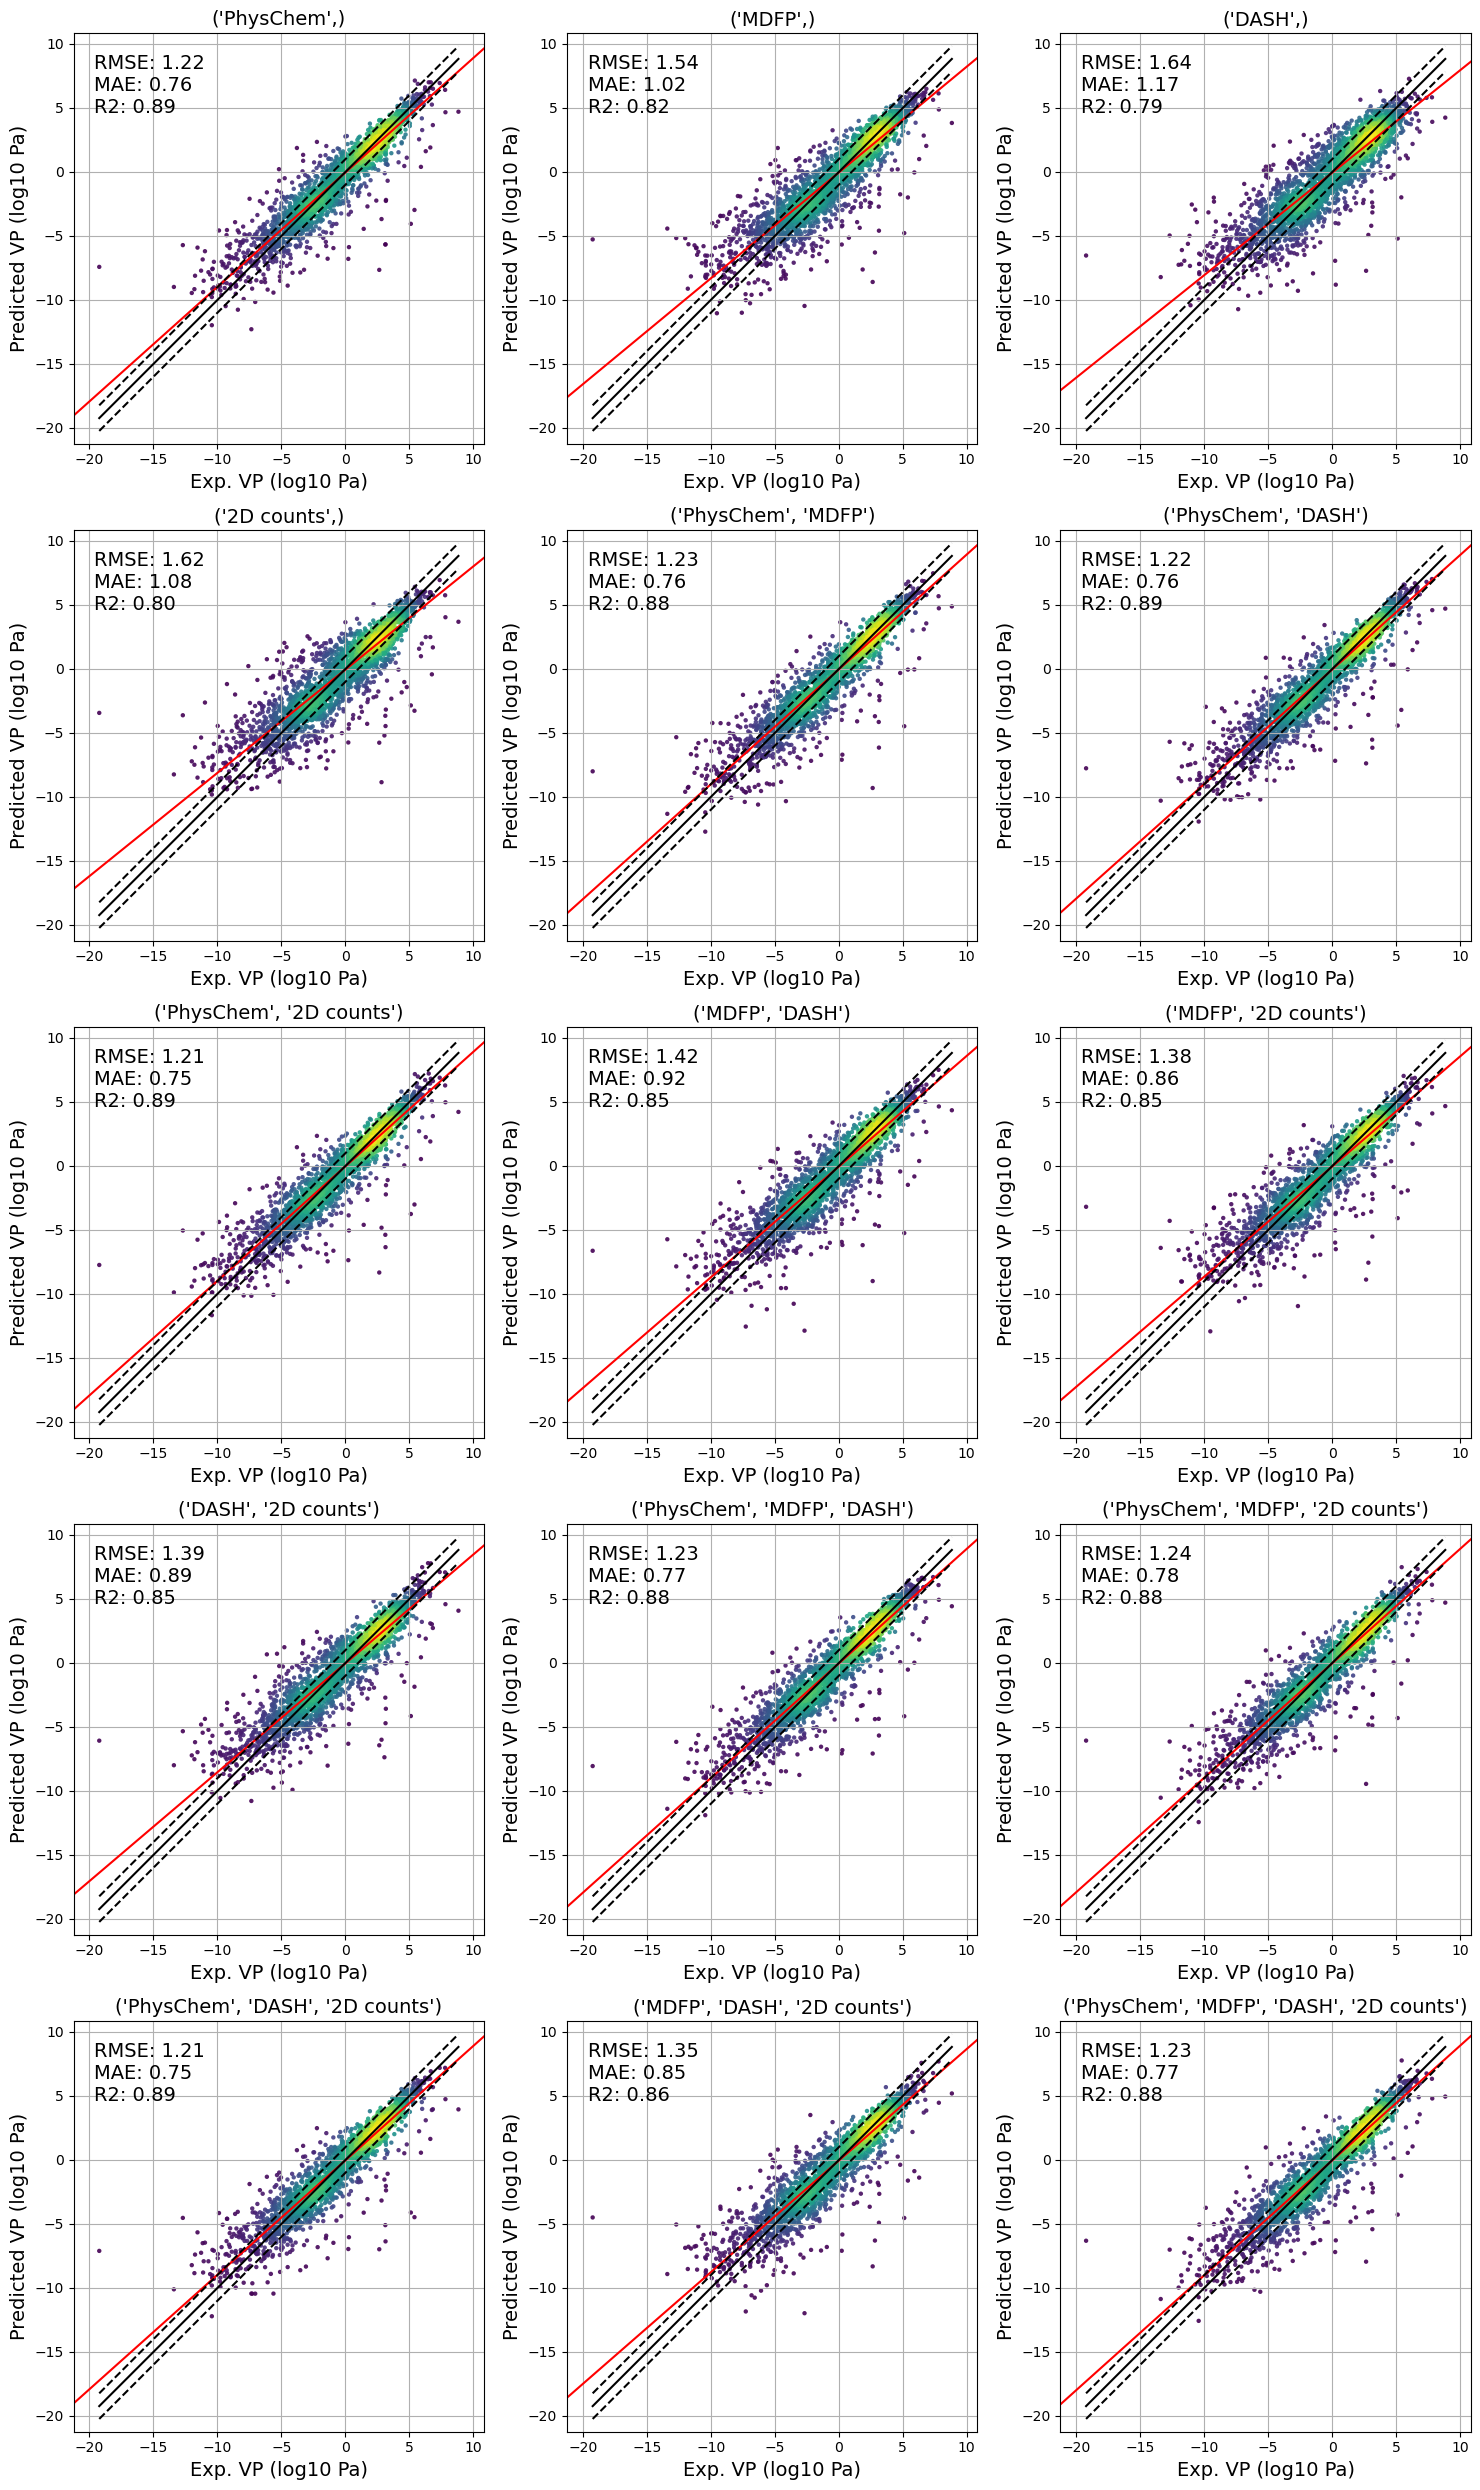

In [13]:
density_plot_multiple(reals =trues, predictions= preds, titles = combinations)

In [14]:
def getStatValues(x,y,get_spearman=False):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    this_rmse = mean_squared_error(np.array(x), np.array(y), squared=False)
    this_mue = mean_absolute_error(np.array(x), np.array(y))
    if not get_spearman:
        return slope, intercept, r_value**2, this_rmse, this_mue
    else:
        import scipy.stats as stats
        spearman = stats.spearmanr(x,y)
        return slope, intercept, r_value**2, this_rmse, this_mue, spearman[0]
def density_plot_multiple_custom(reals, predictions, print_stats=True, bounds=None, titles=None,global_title=None,print_spearman=False):
    num_plots = len(reals)
    num_cols = min(num_plots, 3)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed for the grid
    #if you cant devide by 3, but can divide by 2, do two rows
    if num_plots % 3 != 0 and num_plots % 2 == 0:
        num_rows = 2
        num_cols = 2   
    if num_plots == 4:
        num_rows = 2
        num_cols = 2
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D
    
    for i in range(num_plots):
        real = reals[i]
        prediction = predictions[i]
        if not print_spearman:
            slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(real, prediction)
        else:
            slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae, spearman = getStatValues(real, prediction,get_spearman=True)
            print(f'Spearman: {spearman:.2f}')
        if print_stats:
            print(f'Plot {i + 1} Stats:')
            print('RMSE: ', this_rmse)
            print('MAE: ', this_mae)
            print('R2: ', r2)
        
        ax = axes[i]
        
        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]
        
        x = np.linspace(lower, upper, 100)
        y = slope_mdfp_d * x + intercept_mdfp_d
        ax.plot(x, y, '-r')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')
        import statsmodels.api as sm
        dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")
        ax.axis([lower, upper, lower, upper])
        if not print_spearman:
            ax.text(0.05, 0.95, f'RMSE: {this_rmse:.2f}\nMAE: {this_mae:.2f}\nR2: {r2:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
        else:
            ax.text(0.05, 0.95, f'RMSE: {this_rmse:.2f}\nMAE: {this_mae:.2f}\nR2: {r2:.2f}\nSpearman: {spearman:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
        if titles is not None and len(titles) > i:
            ax.set_title(titles[i], fontsize=14)
        ax.set_aspect('equal', 'box')
    
    # Remove any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    if global_title is not None:
        fig.suptitle(global_title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

Spearman: 0.95
Plot 1 Stats:
RMSE:  1.21649763510845
MAE:  0.760152081586022
R2:  0.8867724950149324
Spearman: 0.93
Plot 2 Stats:
RMSE:  1.541099828911638
MAE:  1.0188906433954923
R2:  0.8182769840089836
Spearman: 0.90
Plot 3 Stats:
RMSE:  1.6434106213655857
MAE:  1.1684643768655936
R2:  0.7932985239285608
Spearman: 0.91
Plot 4 Stats:
RMSE:  1.6159705141287077
MAE:  1.0763765016184939
R2:  0.8001354773791525
Spearman: 0.95
Plot 5 Stats:
RMSE:  1.2293685486995491
MAE:  0.7634843022821507
R2:  0.8844912939065009
Spearman: 0.95
Plot 6 Stats:
RMSE:  1.219613944833091
MAE:  0.7616100369351366
R2:  0.8862100631604791
Spearman: 0.95
Plot 7 Stats:
RMSE:  1.2126756662110791
MAE:  0.7522181798178353
R2:  0.8874769012005379
Spearman: 0.94
Plot 8 Stats:
RMSE:  1.421199255835819
MAE:  0.9228695005763351
R2:  0.8458189318878898
Spearman: 0.94
Plot 9 Stats:
RMSE:  1.3843750661853877
MAE:  0.8617347086714079
R2:  0.8533377373966409
Spearman: 0.94
Plot 10 Stats:
RMSE:  1.38661234020013
MAE:  0.89445010

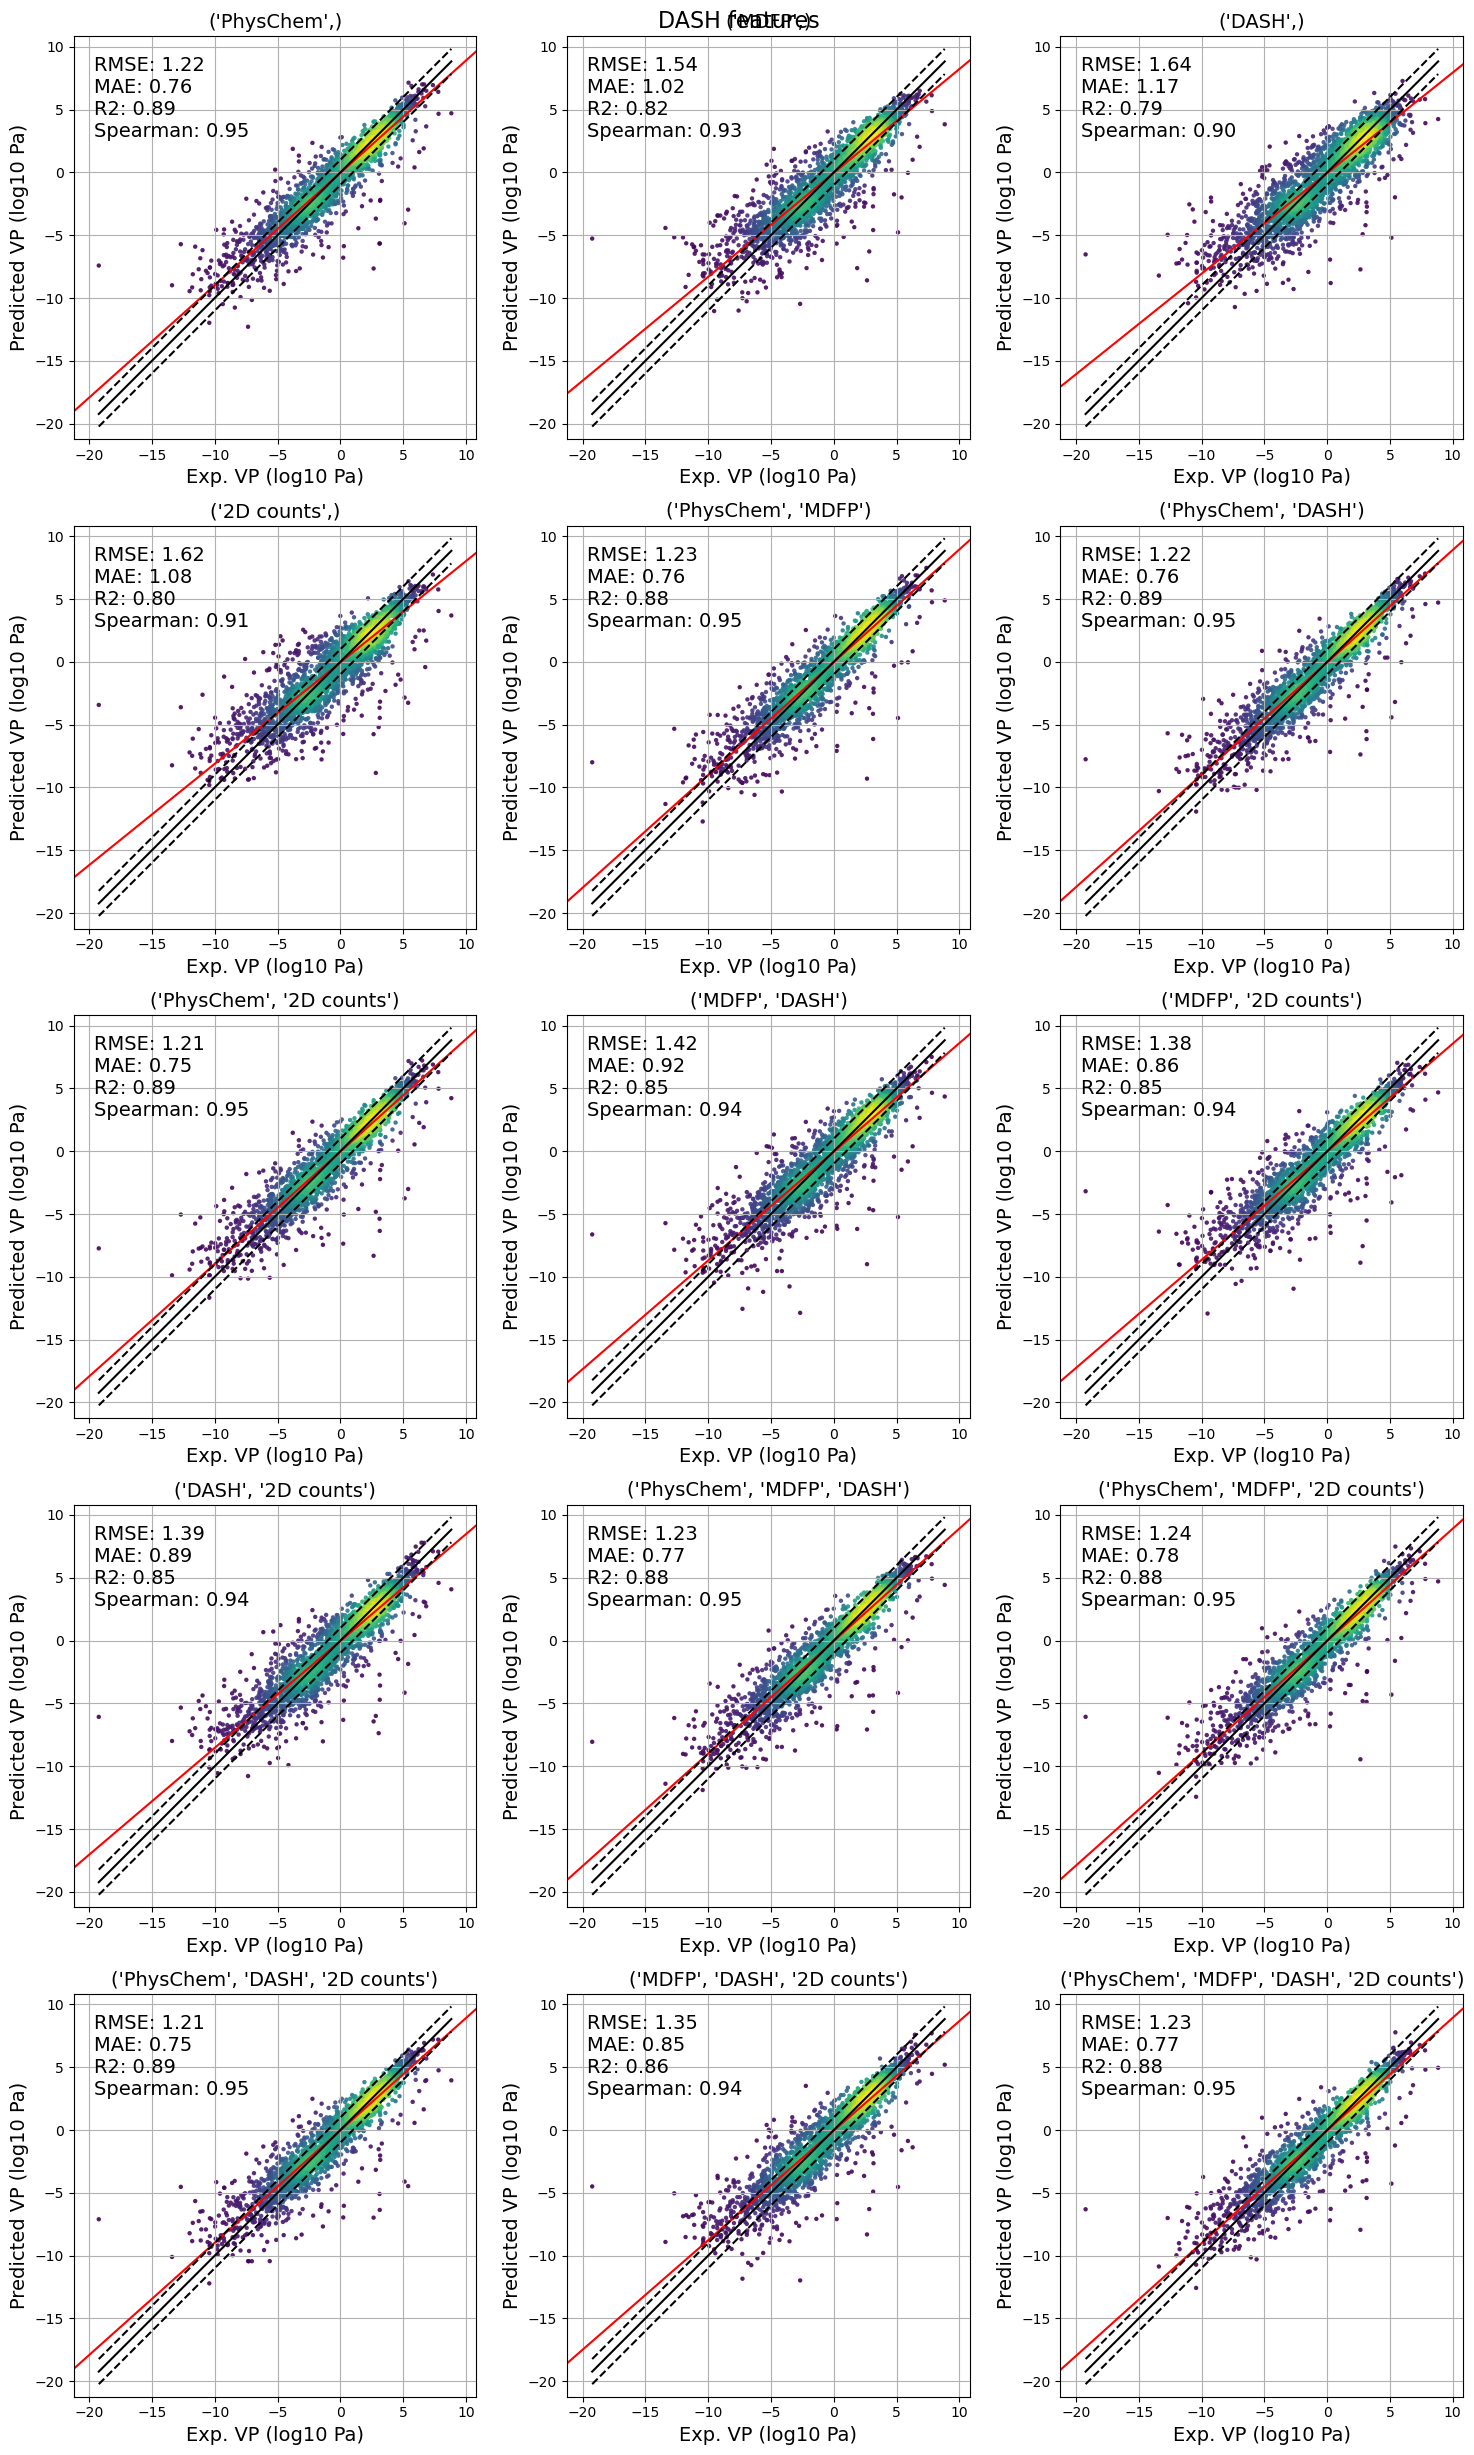

In [15]:
density_plot_multiple_custom(reals =trues, predictions= preds, titles = combinations,global_title='DASH features',print_spearman=True)

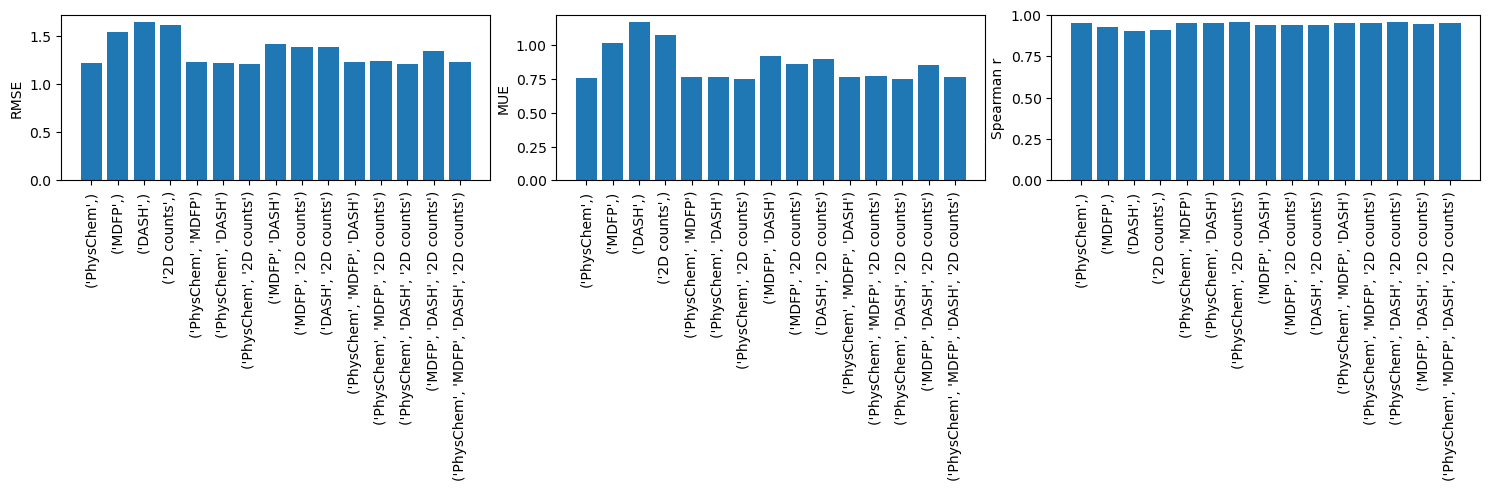

In [16]:
from scipy.stats import spearmanr
rmses,mues,spearmanrs = [],[],[]
for true,pred in zip(trues,preds):
    rmse = mean_squared_error(np.array(true), np.array(pred), squared=False)
    mue = mean_absolute_error(np.array(true), np.array(pred))
    spearmanr_results = spearmanr(np.array(true), np.array(pred))[0]
    rmses.append(rmse)
    mues.append(mue)
    spearmanrs.append(spearmanr_results)
    #now for some more funky metrics: if we have root mean squared error, we can also get the root of the standard deviation of the residuals
    #and the mean of the residuals
    rsse = np.sqrt(np.sum(np.square(np.array(true) - np.array(pred))))
    mre = np.mean(np.array(true) - np.array(pred))
    
#barplot: three subplots side-to-side of the metrics, with the combinations on the x-axis
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].bar(range(len(rmses)), rmses)
ax[0].set_xticks(range(len(rmses)))
ax[0].set_xticklabels(combinations, rotation=90)
ax[0].set_ylabel('RMSE')
ax[1].bar(range(len(mues)), mues)
ax[1].set_xticks(range(len(mues)))
ax[1].set_xticklabels(combinations, rotation=90)
ax[1].set_ylabel('MUE')
ax[2].bar(range(len(spearmanrs)), spearmanrs)
ax[2].set_xticks(range(len(spearmanrs)))
ax[2].set_xticklabels(combinations, rotation=90)
ax[2].set_ylabel('Spearman r')
plt.tight_layout()


In [17]:
def funky_rmses(y_true, y_pred):
    errors = [true - pred for true, pred in zip(y_true, y_pred)]
    RMeanSE = np.sqrt(np.mean(np.square(errors)))
    RStdSE = np.sqrt(np.std(np.square(errors)))
    RMedianSET = np.sqrt(np.median(np.square(errors)))
    return RMeanSE, RStdSE, RMedianSET
    
RMeanSE, RStdSE, RMedianSET = funky_rmses(trues[0], preds[0])
print(RMeanSE)
print(mean_squared_error(trues[0],preds[0],squared=False))
def funky_maes(y_true, y_pred):
    errors = [np.abs(true - pred) for true, pred in zip(y_true, y_pred)]
    RMeanAE = np.mean(errors)
    RStdAE = np.std(errors)
    RMedianAE = np.median(errors)
    return RMeanAE, RStdAE, RMedianAE
RMeanAE, RStdAE, RMedianAE = funky_maes(trues[0], preds[0])
print(RMeanAE)
print(mean_absolute_error(trues[0],preds[0]))

1.21649763510845
1.21649763510845
0.760152081586022
0.760152081586022


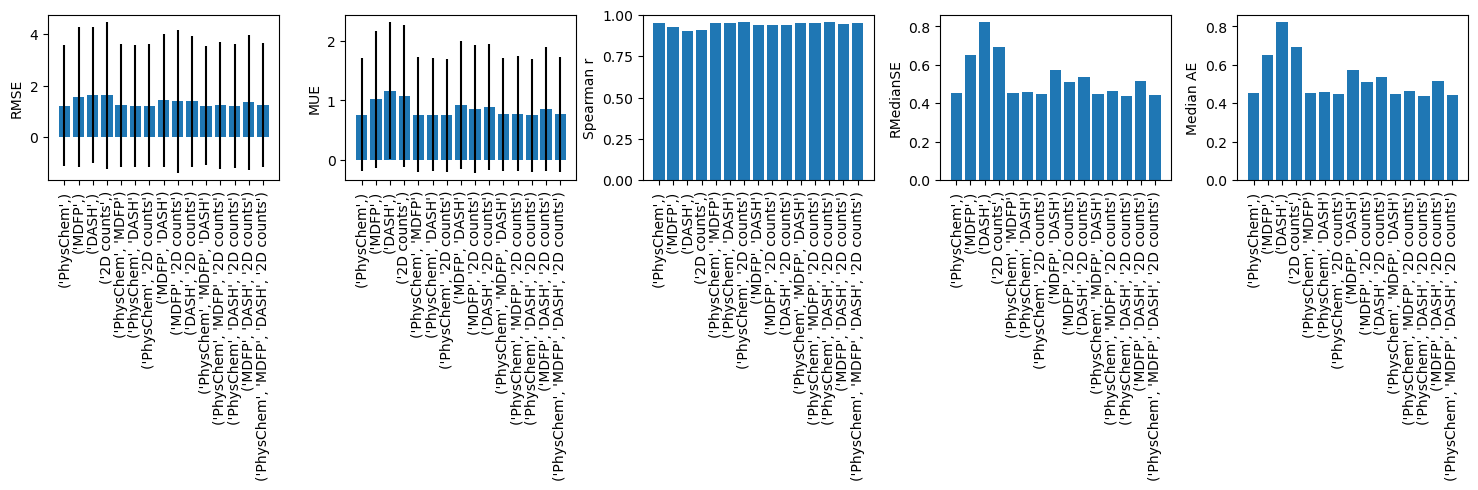

In [18]:
from scipy.stats import spearmanr
rmses,mues,spearmanrs = [],[],[]
rssesm,sues = [],[]
rmedianses = []
median_absolute_errors = []
for true,pred in zip(trues,preds):
    RMeanSE, RStdSE, RMedianSET = funky_rmses(true, pred)
    RMeanAE, RStdAE, RMedianAE = funky_maes(true, pred)
    spearmanr_results = spearmanr(np.array(true), np.array(pred))[0]
    rmses.append(RMeanSE)
    mues.append(RMeanAE)
    spearmanrs.append(spearmanr_results)
    rssesm.append(RStdSE)
    sues.append(RStdAE)
    rmedianses.append(RMedianSET)
    median_absolute_errors.append(RMedianAE)
    
#barplot: three subplots side-to-side of the metrics, with the combinations on the x-axis rssesm as error bar for rmse, sues for mae
fig, ax = plt.subplots(1,5,figsize=(15,5))
ax[0].bar(range(len(rmses)), rmses, yerr=rssesm)
ax[0].set_xticks(range(len(rmses)))
ax[0].set_xticklabels(combinations, rotation=90)
ax[0].set_ylabel('RMSE')
ax[1].bar(range(len(mues)), mues, yerr=sues)
ax[1].set_xticks(range(len(mues)))
ax[1].set_xticklabels(combinations, rotation=90)
ax[1].set_ylabel('MUE')
ax[2].bar(range(len(spearmanrs)), spearmanrs)
ax[2].set_xticks(range(len(spearmanrs)))
ax[2].set_xticklabels(combinations, rotation=90)
ax[2].set_ylabel('Spearman r')
ax[3].bar(range(len(rmedianses)), rmedianses)
ax[3].set_xticks(range(len(rmedianses)))
ax[3].set_xticklabels(combinations, rotation=90)
ax[3].set_ylabel('RMedianSE')
ax[4].bar(range(len(median_absolute_errors)), median_absolute_errors)
ax[4].set_xticks(range(len(median_absolute_errors)))
ax[4].set_xticklabels(combinations, rotation=90)
ax[4].set_ylabel('Median AE')


plt.tight_layout()




In [19]:
reals

NameError: name 'reals' is not defined

In [ ]:
density_plot_multiple(reals = [r[1] for r in results], predictions= [r[2] for r in results], titles = [str(r[0]) for r in results])

Plot 1 Stats:
RMSE:  1.234665475202182
MAE:  0.7540896397154404
R2:  0.8834455768024155
Plot 2 Stats:
RMSE:  1.239741481743788
MAE:  0.7593118951160274
R2:  0.8825073441447808
Plot 3 Stats:
RMSE:  1.2500632029487646
MAE:  0.7764053037890841
R2:  0.8804210629348939
Plot 4 Stats:
RMSE:  1.247337201407613
MAE:  0.7743488177164358
R2:  0.8809546820934782
Plot 5 Stats:
RMSE:  1.246337485497972
MAE:  0.7729957718537545
R2:  0.8812257190400823
Plot 6 Stats:
RMSE:  1.2308608054107144
MAE:  0.7585459452903419
R2:  0.8841749773129971
Plot 7 Stats:
RMSE:  1.244605560106735
MAE:  0.7687154257825896
R2:  0.8814368696998429
Plot 8 Stats:
RMSE:  1.2308608054107144
MAE:  0.7585459452903419
R2:  0.8841749773129971
Plot 9 Stats:
RMSE:  1.2506135502301594
MAE:  0.7731779336828416
R2:  0.8804904093679026
Plot 10 Stats:
RMSE:  1.2506135502301594
MAE:  0.7731779336828416
R2:  0.8804904093679026
Plot 11 Stats:
RMSE:  1.239741481743788
MAE:  0.7593118951160274
R2:  0.8825073441447808
Plot 12 Stats:
RMSE:  1.2

RuntimeError: In draw_glyphs_to_bitmap: Could not convert glyph to bitmap (raster overflow; error code 0x62)

<Figure size 1500x7500 with 43 Axes>

In [ ]:
density_plot_multiple

In [20]:
output_2d_only = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names,y_label='vp_log10pa')
real_2d_only, prediction_2d_only = (reduce(lambda a,b : list(a)+list(b) , output_2d_only[0]), reduce(lambda a,b : list(a)+list(b), output_2d_only[1]))

In [21]:
output_mdfp_only = train_pred_xgboost_2d(df,params=params,X_features=mdfp_features_full,y_label='vp_log10pa')
real_mdfp_only, prediction_mdfp_only = (reduce(lambda a,b : list(a)+list(b) , output_mdfp_only[0]), reduce(lambda a,b : list(a)+list(b), output_mdfp_only[1]))

In [22]:
output_physchem_plus_dash = train_pred_xgboost_2d(df,params=params,X_features=RDKit_feature_names+DASH_props_names,y_label='vp_log10pa')
real_physchem_plus_dash, prediction_physchem_plus_dash = (reduce(lambda a,b : list(a)+list(b) , output_physchem_plus_dash[0]), reduce(lambda a,b : list(a)+list(b), output_physchem_plus_dash[1]))

In [23]:
output_mdfp_plus_dash = train_pred_xgboost_2d(df,params=params,X_features=mdfp_features_full+DASH_props_names,y_label='vp_log10pa')
real_mdfp_plus_dash, prediction_mdfp_plus_dash = (reduce(lambda a,b : list(a)+list(b) , output_mdfp_plus_dash[0]), reduce(lambda a,b : list(a)+list(b), output_mdfp_plus_dash[1]))

In [24]:
output_dash_only = train_pred_xgboost_2d(df,params=params,X_features=DASH_props_names,y_label='vp_log10pa')
real_dash_only, prediction_dash_only = (reduce(lambda a,b : list(a)+list(b) , output_dash_only[0]), reduce(lambda a,b : list(a)+list(b), output_dash_only[1]))

Plot 1 Stats:
RMSE:  1.21649763510845
MAE:  0.760152081586022
R2:  0.8867724950149324
Plot 2 Stats:
RMSE:  1.3831947977793415
MAE:  0.8621406941337203
R2:  0.8535845009455079
Plot 3 Stats:
RMSE:  1.219613944833091
MAE:  0.7616100369351366
R2:  0.8862100631604791
Plot 4 Stats:
RMSE:  1.348158913229447
MAE:  0.8509389988151109
R2:  0.8610043671085799


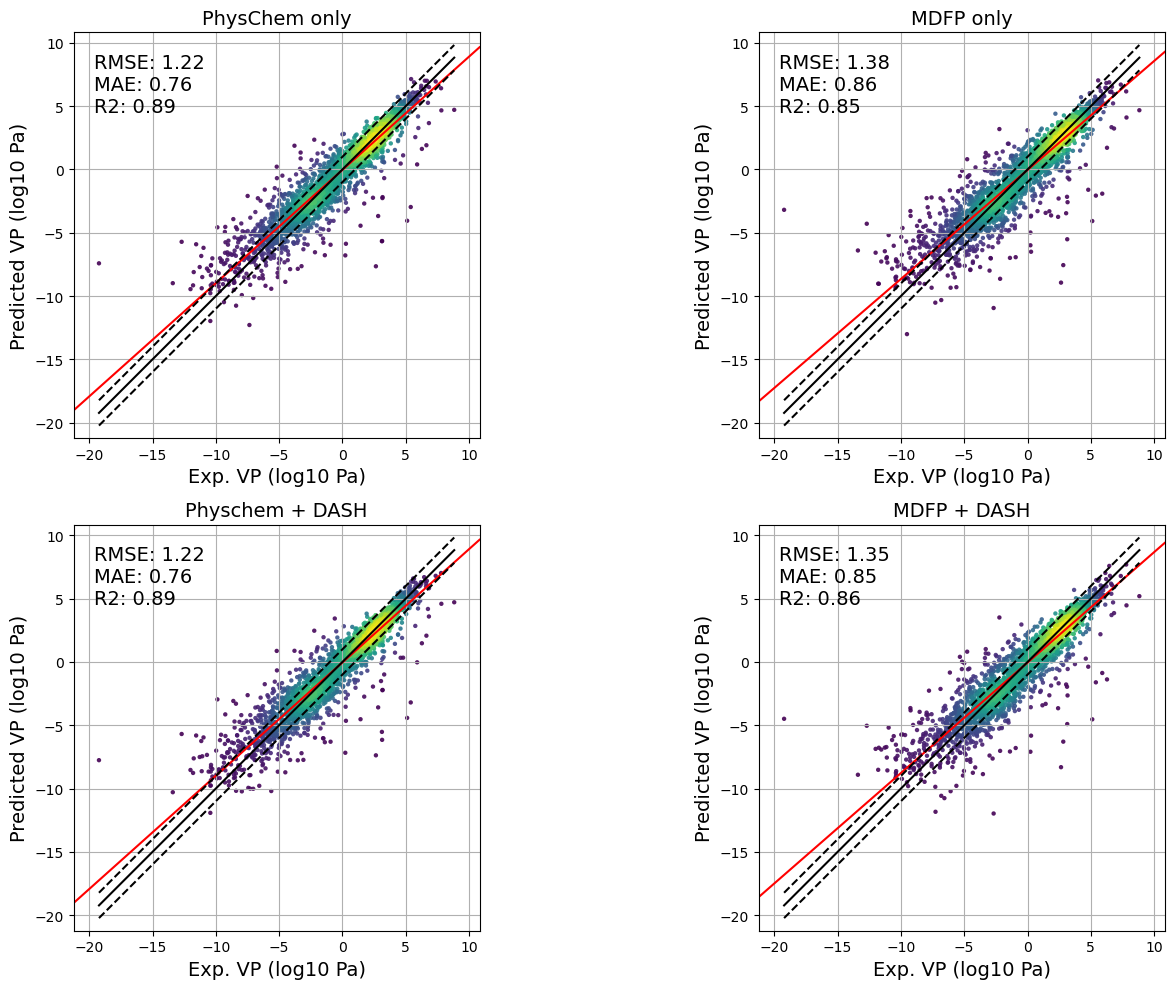

In [25]:
density_plot_multiple(reals = [real_2d_only,real_mdfp_only, real_physchem_plus_dash, real_mdfp_plus_dash],
                      predictions = [prediction_2d_only,prediction_mdfp_only, prediction_physchem_plus_dash, prediction_mdfp_plus_dash],
                      titles = ['PhysChem only','MDFP only','Physchem + DASH','MDFP + DASH'])

Plot 1 Stats:
RMSE:  1.21649763510845
MAE:  0.760152081586022
R2:  0.8867724950149324
Plot 2 Stats:
RMSE:  1.3831947977793415
MAE:  0.8621406941337203
R2:  0.8535845009455079
Plot 3 Stats:
RMSE:  1.219613944833091
MAE:  0.7616100369351366
R2:  0.8862100631604791
Plot 4 Stats:
RMSE:  1.348158913229447
MAE:  0.8509389988151109
R2:  0.8610043671085799
Plot 5 Stats:
RMSE:  1.6434106213655857
MAE:  1.1684643768655936
R2:  0.7932985239285608


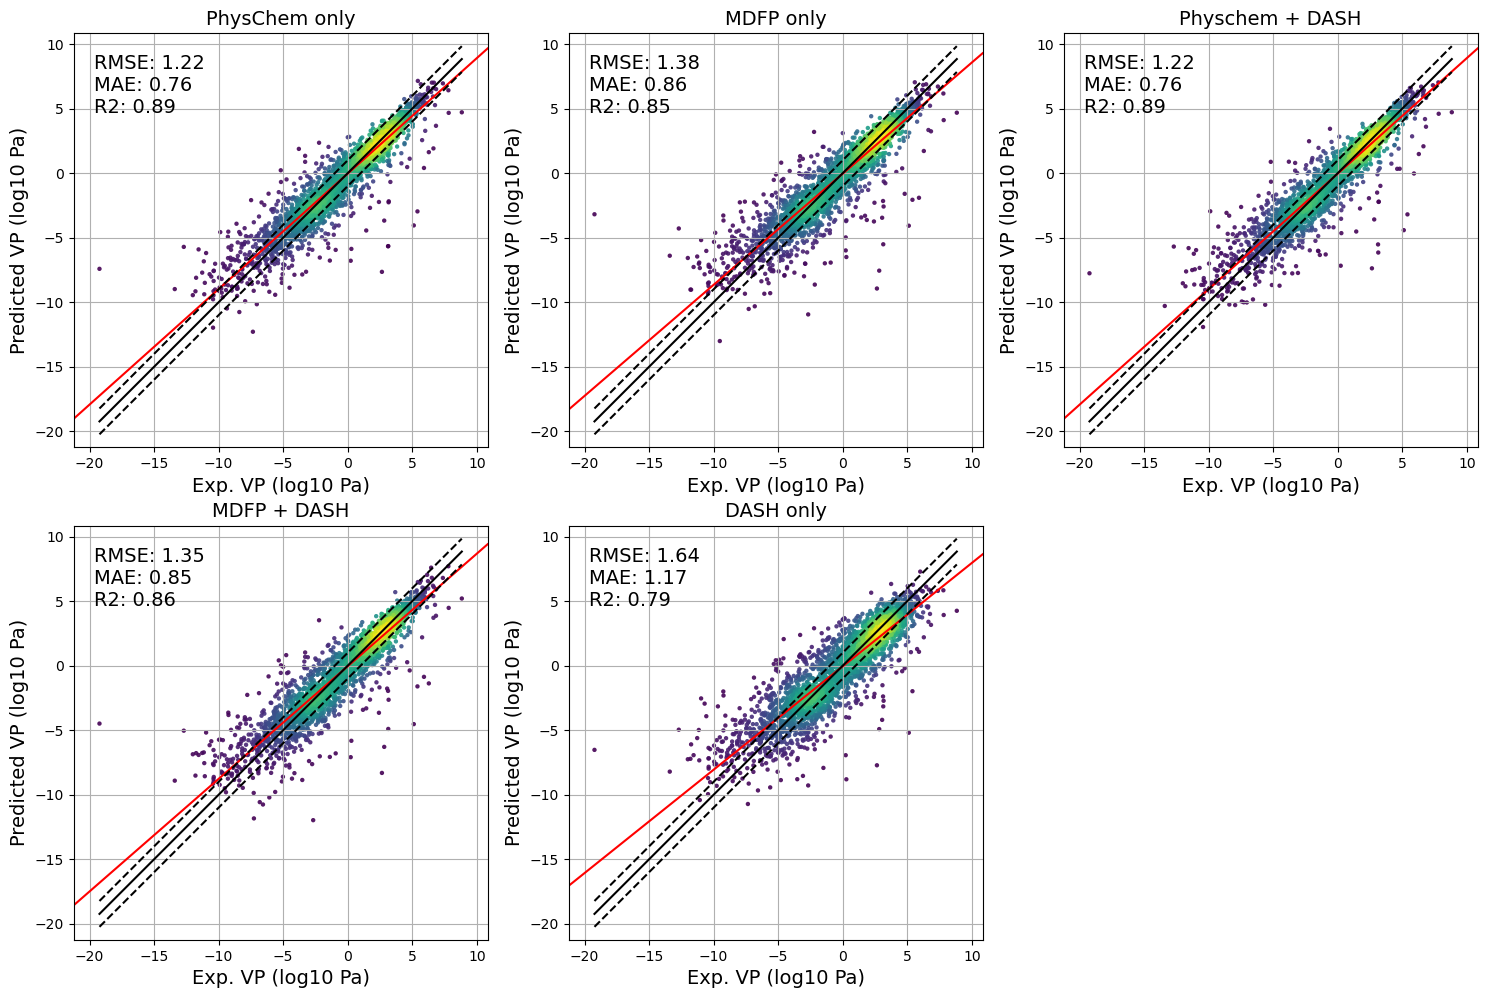

In [26]:
density_plot_multiple(reals = [real_2d_only,real_mdfp_only, real_physchem_plus_dash, real_mdfp_plus_dash, real_dash_only],
                      predictions = [prediction_2d_only,prediction_mdfp_only, prediction_physchem_plus_dash, prediction_mdfp_plus_dash, prediction_dash_only],
                      titles = ['PhysChem only','MDFP only','Physchem + DASH','MDFP + DASH','DASH only','DASH + MolWt','MolWt only'])

In [27]:

def train_pred_xgboost_2d_local(df,params,X_features,y_label,splits=5,scale = True):

    X = df[X_features]
    X = X.to_numpy()
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    y = df[y_label]
    kf = KFold(n_splits=splits)
    output = ([], [])

    for train, test in kf.split(X):
            
            train_x = np.array(X)[train]
            train_y = np.array(y)[train]
    
            test_x = np.array(X)[test]
            test_y = np.array(y)[test]
            
            dtrain = xgb.DMatrix(train_x, label=train_y)
            dtest = xgb.DMatrix(test_x, label=test_y)

            model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            evals=[(dtest, "Test")],
            early_stopping_rounds=10,
            verbose_eval=False
            )

            predictions = model.predict(dtest)
    
            output[0].append(test_y)
            output[1].append(predictions)

    return output,model

In [28]:
output_dash_only,model_dash_only = train_pred_xgboost_2d_local(df,params=params,X_features=DASH_props_names,y_label='vp_log10pa')
importance = model_dash_only.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
importance = {DASH_props_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance



[('DASH_max_abs_mbis', 81.0),
 ('DASH_avg_abs_mbis', 70.0),
 ('DASH_num_atoms', 70.0),
 ('DASH_lumo', 64.0),
 ('DASH_homo', 57.0),
 ('DASH_>03_abs_mbis', 57.0),
 ('DASH_conj', 56.0),
 ('DASH_dual_elec', 12.0),
 ('DASH_dual_nucl', 4.0)]

In [29]:
output_dash_only,model_dash_only = train_pred_xgboost_2d_local(df,params=params,X_features=DASH_props_names,y_label='vp_log10pa')
importance = model_dash_only.get_score(importance_type='gain')
#use actual feature names: DASH_props_names
importance = {DASH_props_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance

[('DASH_num_atoms', 370.9934387207031),
 ('DASH_conj', 283.45880126953125),
 ('DASH_>03_abs_mbis', 83.60504913330078),
 ('DASH_max_abs_mbis', 32.369659423828125),
 ('DASH_avg_abs_mbis', 31.073007583618164),
 ('DASH_lumo', 20.07010841369629),
 ('DASH_dual_elec', 13.823074340820312),
 ('DASH_homo', 12.585101127624512),
 ('DASH_dual_nucl', 5.876979351043701)]

In [30]:
output_mdfp_plus_dash,model_mdfp_plus_dash = train_pred_xgboost_2d_local(df,params=params,X_features=mdfp_features_full+DASH_props_names,y_label='vp_log10pa')
importance = model_mdfp_plus_dash.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
dash_plus_mdfp_names  = mdfp_features_full+DASH_props_names
importance = {dash_plus_mdfp_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance





[('DASH_max_abs_mbis', 18.0),
 ('NumHeavyAtoms', 17.0),
 ('DASH_conj', 16.0),
 ('water_rgyr_mean', 15.0),
 ('DASH_>03_abs_mbis', 15.0),
 ('water_total_crf_std', 14.0),
 ('water_total_lj_std', 14.0),
 ('water_total_ene_std', 13.0),
 ('water_intra_crf_mean', 11.0),
 ('DASH_avg_abs_mbis', 11.0),
 ('NumF', 10.0),
 ('water_intra_crf_std', 9.0),
 ('water_total_lj_mean', 9.0),
 ('water_sasa_std', 9.0),
 ('NumN', 7.0),
 ('water_rgyr_std', 7.0),
 ('DASH_lumo', 7.0),
 ('water_rgyr_median', 6.0),
 ('water_sasa_mean', 6.0),
 ('NumRotatableBonds', 5.0),
 ('NumO', 5.0),
 ('NumBr', 5.0),
 ('water_intra_lj_std', 5.0),
 ('water_total_crf_mean', 5.0),
 ('DASH_homo', 5.0),
 ('water_intra_lj_mean', 4.0),
 ('NumS', 3.0),
 ('NumI', 3.0),
 ('water_intra_ene_std', 3.0),
 ('water_total_ene_mean', 3.0),
 ('DASH_num_atoms', 3.0),
 ('NumCl', 2.0),
 ('water_total_lj_median', 2.0),
 ('water_total_ene_median', 2.0),
 ('water_intra_crf_median', 1.0),
 ('water_intra_lj_median', 1.0),
 ('water_intra_ene_mean', 1.0),
 (

In [31]:
output_mdfp_plus_dash,model_mdfp_plus_dash = train_pred_xgboost_2d_local(df,params=params,X_features=mdfp_features_full+DASH_props_names,y_label='vp_log10pa')
importance = model_mdfp_plus_dash.get_score(importance_type='gain')
#use actual feature names: DASH_props_names
dash_plus_mdfp_names  = mdfp_features_full+DASH_props_names
importance = {dash_plus_mdfp_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance



[('NumHeavyAtoms', 2156.81884765625),
 ('water_total_ene_std', 366.7966003417969),
 ('water_total_crf_std', 228.7455596923828),
 ('water_intra_lj_mean', 159.45970153808594),
 ('DASH_conj', 127.148681640625),
 ('water_total_lj_std', 125.72473907470703),
 ('NumF', 93.10816192626953),
 ('DASH_>03_abs_mbis', 90.67037200927734),
 ('NumN', 71.95250701904297),
 ('water_rgyr_mean', 56.20126724243164),
 ('water_intra_ene_mean', 47.847999572753906),
 ('water_rgyr_median', 47.75922775268555),
 ('NumRotatableBonds', 43.582603454589844),
 ('DASH_avg_abs_mbis', 43.07859802246094),
 ('water_total_ene_median', 34.17233657836914),
 ('DASH_num_atoms', 31.991487503051758),
 ('water_intra_lj_median', 30.68170928955078),
 ('water_sasa_std', 30.363197326660156),
 ('water_sasa_mean', 29.41168975830078),
 ('DASH_homo', 26.0441951751709),
 ('water_total_ene_mean', 24.73581886291504),
 ('NumS', 22.9858341217041),
 ('water_rgyr_std', 21.542964935302734),
 ('NumBr', 21.47900390625),
 ('water_total_crf_mean', 19.6

In [32]:
#replace estate by dashprops
custom_estate = RDKit_feature_names.copy()
custom_estate = [f for f in custom_estate if 'EState' not in f]
custom_estate = [f for f in custom_estate if 'Charge' not in f]
custom_estate += DASH_props_names
custom_estate

['qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'S

Plot 1 Stats:
RMSE:  1.21649763510845
MAE:  0.760152081586022
R2:  0.8867724950149324
Plot 2 Stats:
RMSE:  1.2368864994432565
MAE:  0.7699384044905417
R2:  0.8829865430279927


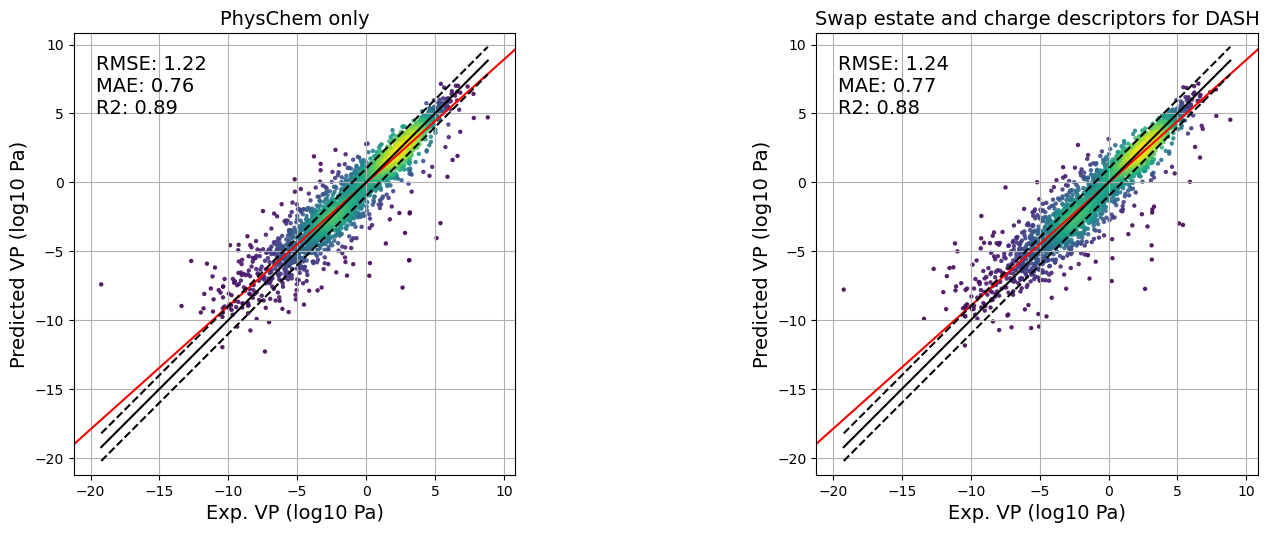

In [33]:
custom_estate_out,model_custom_estate = train_pred_xgboost_2d_local(df,params=params,X_features=custom_estate,y_label='vp_log10pa')
realcustom_estate, prediction_custom_estate = (reduce(lambda a,b : list(a)+list(b) , custom_estate_out[0]), reduce(lambda a,b : list(a)+list(b), custom_estate_out[1]))
density_plot_multiple(reals = [real_2d_only,realcustom_estate],
                      predictions = [prediction_2d_only,prediction_custom_estate],
                      titles = ['PhysChem only','Swap estate and charge descriptors for DASH'])

In [34]:
importance = model_custom_estate.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
importance = {custom_estate[int(k[1:])]:v for k,v in importance.items()}
importance_list = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance_list



[('TPSA', 16.0),
 ('Chi1v', 9.0),
 ('BCUT2D_LOGPLOW', 8.0),
 ('qed', 7.0),
 ('BalabanJ', 7.0),
 ('PEOE_VSA10', 7.0),
 ('MolMR', 7.0),
 ('SMR_VSA2', 6.0),
 ('NHOHCount', 6.0),
 ('MolLogP', 6.0),
 ('BCUT2D_CHGHI', 5.0),
 ('Chi2n', 5.0),
 ('Chi3n', 5.0),
 ('PEOE_VSA14', 5.0),
 ('SMR_VSA10', 5.0),
 ('SlogP_VSA3', 5.0),
 ('NumHDonors', 5.0),
 ('DASH_lumo', 5.0),
 ('DASH_max_abs_mbis', 5.0),
 ('BCUT2D_MWHI', 4.0),
 ('BCUT2D_CHGLO', 4.0),
 ('AvgIpc', 4.0),
 ('BertzCT', 4.0),
 ('Chi3v', 4.0),
 ('Chi4v', 4.0),
 ('HallKierAlpha', 4.0),
 ('PEOE_VSA1', 4.0),
 ('PEOE_VSA3', 4.0),
 ('PEOE_VSA7', 4.0),
 ('HeavyAtomCount', 4.0),
 ('DASH_>03_abs_mbis', 4.0),
 ('DASH_conj', 4.0),
 ('FpDensityMorgan1', 3.0),
 ('BCUT2D_MWLOW', 3.0),
 ('Kappa1', 3.0),
 ('PEOE_VSA6', 3.0),
 ('PEOE_VSA8', 3.0),
 ('SMR_VSA4', 3.0),
 ('SlogP_VSA1', 3.0),
 ('SlogP_VSA10', 3.0),
 ('SlogP_VSA11', 3.0),
 ('fr_bicyclic', 3.0),
 ('DASH_homo', 3.0),
 ('MolWt', 2.0),
 ('FpDensityMorgan3', 2.0),
 ('BCUT2D_MRLOW', 2.0),
 ('Chi0', 2.0),


RMSE:  1.4263848768066316
MAE:  0.9156302955432464
R2:  0.8442847236731382


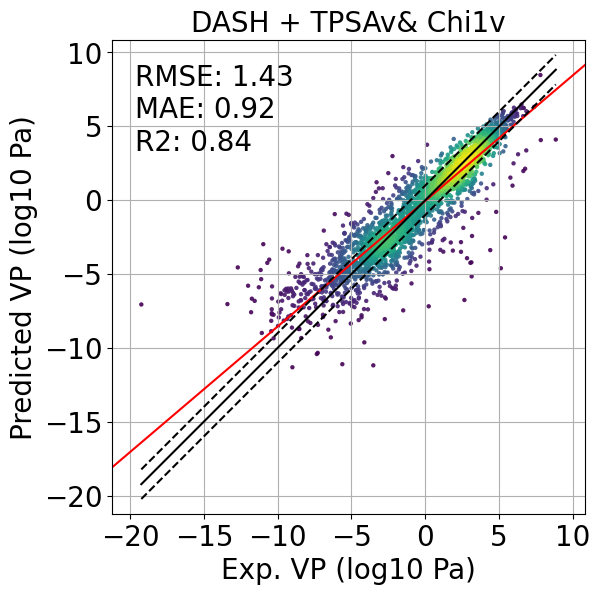

In [35]:
custom_features = DASH_props_names + ['TPSA','Chi1v']
output_mdfp_custom_features,model_mdfp_custom_features = train_pred_xgboost_2d_local(df,params=params,X_features=custom_features,y_label='vp_log10pa')
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output_mdfp_custom_features[0]), reduce(lambda a,b : list(a)+list(b), output_mdfp_custom_features[1]))
density_plot(real = real, prediction = prediction, title = 'DASH + TPSAv& Chi1v')


Plot 1 Stats:
RMSE:  1.6434106213655857
MAE:  1.1684643768655936
R2:  0.7932985239285608
Plot 2 Stats:
RMSE:  1.5980320423598582
MAE:  1.071471647241831
R2:  0.8045339269645876
Plot 3 Stats:
RMSE:  1.6185006390088124
MAE:  1.079750053212734
R2:  0.7995067950786643


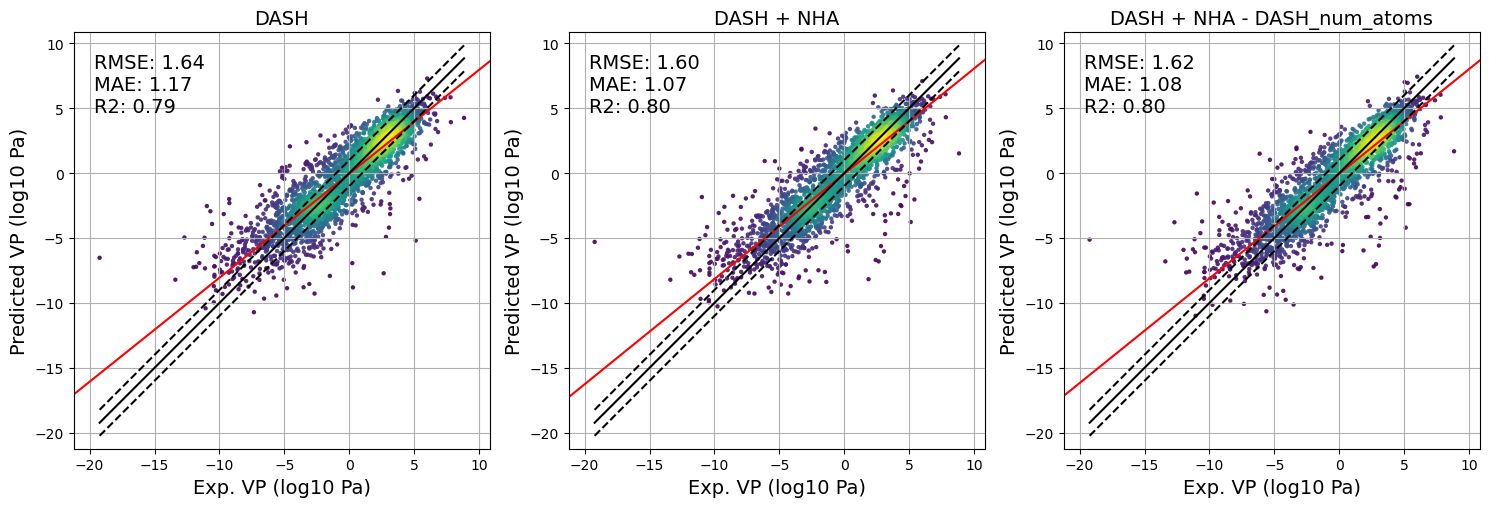

In [36]:
custom_features_nha = DASH_props_names + ['NumHeavyAtoms']
custom_features_rm_na = custom_features_nha.copy()
custom_features_rm_na.remove('DASH_num_atoms')
output_dash,model_dash = train_pred_xgboost_2d_local(df,params=params,X_features=DASH_props_names,y_label='vp_log10pa')
real_dash, prediction_dash = (reduce(lambda a,b : list(a)+list(b) , output_dash[0]), reduce(lambda a,b : list(a)+list(b), output_dash[1]))

output_dash_nha ,model_dash_nha = train_pred_xgboost_2d_local(df,params=params,X_features=custom_features_nha,y_label='vp_log10pa')
real_dash_nha, prediction_dash_nha = (reduce(lambda a,b : list(a)+list(b) , output_dash_nha[0]), reduce(lambda a,b : list(a)+list(b), output_dash_nha[1]))

output_dash_rm_ha ,model_dash_rm_ha = train_pred_xgboost_2d_local(df,params=params,X_features=custom_features_rm_na,y_label='vp_log10pa')
real_dash_rm_ha, prediction_dash_rm_ha = (reduce(lambda a,b : list(a)+list(b) , output_dash_rm_ha[0]), reduce(lambda a,b : list(a)+list(b), output_dash_rm_ha[1]))

density_plot_multiple(reals = [real_dash,real_dash_nha,real_dash_rm_ha],predictions=[prediction_dash,prediction_dash_nha,prediction_dash_rm_ha],titles=['DASH','DASH + NHA','DASH + NHA - DASH_num_atoms'])

Plot 1 Stats:
RMSE:  1.6434106213655857
MAE:  1.1684643768655936
R2:  0.7932985239285608
Plot 2 Stats:
RMSE:  1.38661234020013
MAE:  0.8944501053307325
R2:  0.8528203610267098
Plot 3 Stats:
RMSE:  1.21649763510845
MAE:  0.760152081586022
R2:  0.8867724950149324
Plot 4 Stats:
RMSE:  1.3598651378445603
MAE:  0.8714293940941086
R2:  0.8584865910398906


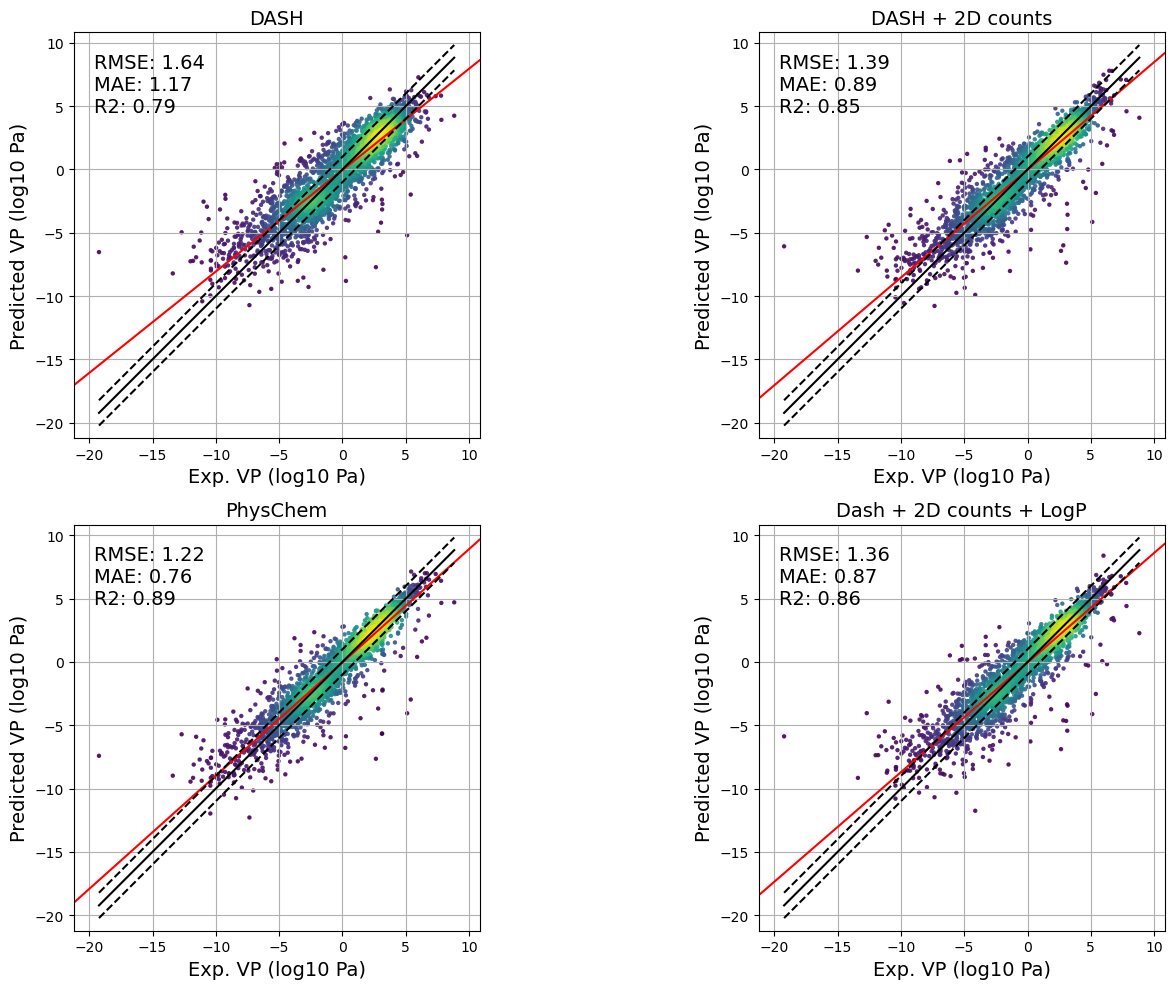

In [37]:
dash_plus_2d_counts = DASH_props_names + mdfp_2d_features
output_dash_plus_2d_counts ,model_dash_plus_2d_counts = train_pred_xgboost_2d_local(df,params=params,X_features=dash_plus_2d_counts,y_label='vp_log10pa')
real_dash_plus_2d_counts, prediction_dash_plus_2d_counts = (reduce(lambda a,b : list(a)+list(b) , output_dash_plus_2d_counts[0]), reduce(lambda a,b : list(a)+list(b), output_dash_plus_2d_counts[1]))

dash_plus_2d_counts_plus_logp= DASH_props_names + mdfp_2d_features + ['AvgIpc']
output_dash_plus_2d_counts_plus_logp ,model_dash_plus_2d_counts_plus_logp = train_pred_xgboost_2d_local(df,params=params,X_features=dash_plus_2d_counts_plus_logp,y_label='vp_log10pa')
real_dash_plus_2d_counts_plus_logp, prediction_dash_plus_2d_counts_plus_logp = (reduce(lambda a,b : list(a)+list(b) , output_dash_plus_2d_counts_plus_logp[0]), reduce(lambda a,b : list(a)+list(b), output_dash_plus_2d_counts_plus_logp[1]))


density_plot_multiple(reals=[real_dash,real_dash_plus_2d_counts,real_2d_only,real_dash_plus_2d_counts_plus_logp],predictions=[prediction_dash,prediction_dash_plus_2d_counts,prediction_2d_only,prediction_dash_plus_2d_counts_plus_logp],titles=['DASH','DASH + 2D counts','PhysChem','Dash + 2D counts + LogP'])



In [38]:
for f in RDKit_feature_names:
    dash_plus_2d_counts_plus_logp= DASH_props_names + mdfp_2d_features + [f]
    output_dash_plus_2d_counts_plus_logp ,model_dash_plus_2d_counts_plus_logp = train_pred_xgboost_2d_local(df,params=params,X_features=dash_plus_2d_counts_plus_logp,y_label='vp_log10pa')
    real_dash_plus_2d_counts_plus_logp, prediction_dash_plus_2d_counts_plus_logp = (reduce(lambda a,b : list(a)+list(b) , output_dash_plus_2d_counts_plus_logp[0]), reduce(lambda a,b : list(a)+list(b), output_dash_plus_2d_counts_plus_logp[1]))
    slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(real_dash_plus_2d_counts_plus_logp, prediction_dash_plus_2d_counts_plus_logp)
    if this_mae < 0.89 and this_rmse < 1.38 and r2 > 0.86:
        print(f)
        print('RMSE: ', this_rmse)
        print('MAE: ', this_mae)
        print('R2: ', r2)

MinPartialCharge
RMSE:  1.3491452242797966
MAE:  0.8527041279590324
R2:  0.8606676794683629
MaxAbsPartialCharge
RMSE:  1.336921364013079
MAE:  0.8455562500050717
R2:  0.8632309189890859
PEOE_VSA1
RMSE:  1.3478385634013281
MAE:  0.8442783835763614
R2:  0.8609331189392474
NHOHCount
RMSE:  1.3085619138789018
MAE:  0.8283836387509348
R2:  0.8689125720071913
NumHDonors
RMSE:  1.3135328479534514
MAE:  0.844625281435788
R2:  0.8679081488139707


Plot 1 Stats:
RMSE:  1.6434106213655857
MAE:  1.1684643768655936
R2:  0.7932985239285608
Plot 2 Stats:
RMSE:  1.38661234020013
MAE:  0.8944501053307325
R2:  0.8528203610267098
Plot 3 Stats:
RMSE:  1.21649763510845
MAE:  0.760152081586022
R2:  0.8867724950149324
Plot 4 Stats:
RMSE:  1.3794058935853175
MAE:  0.8870109245581673
R2:  0.8543465102328017
Plot 5 Stats:
RMSE:  1.2149386321472913
MAE:  0.750596735730538
R2:  0.8870502335219332
Plot 6 Stats:
RMSE:  1.234482045624853
MAE:  0.7650798244466965
R2:  0.8835505704102177


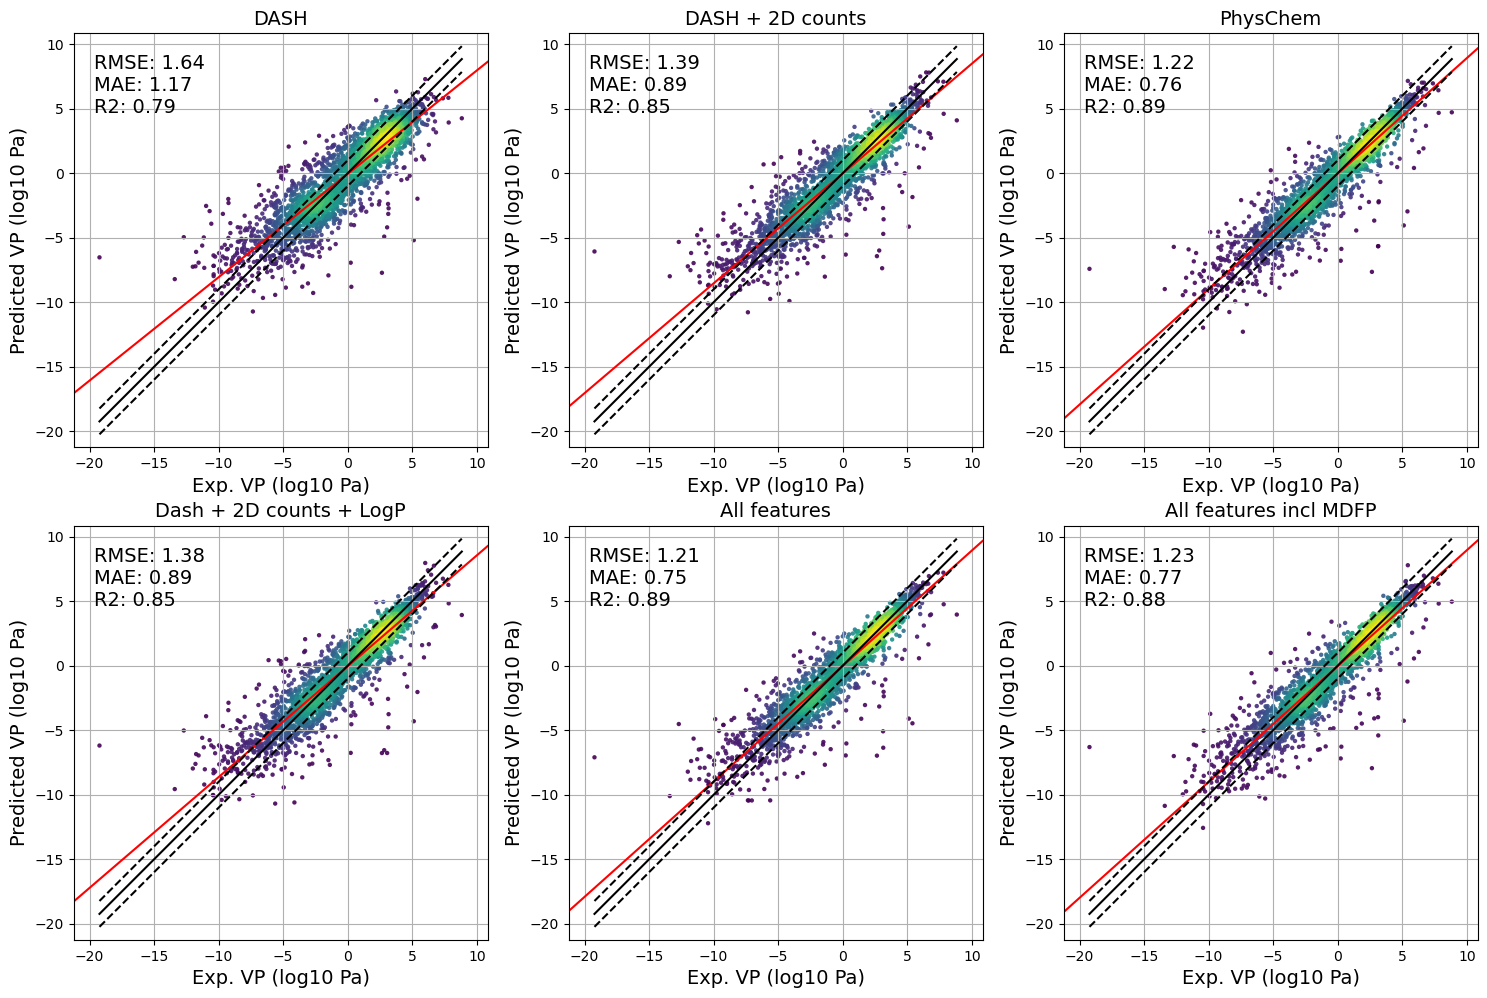

In [39]:
all_features = DASH_props_names + mdfp_2d_features + RDKit_feature_names
output_all_features ,model_all_features = train_pred_xgboost_2d_local(df,params=params,X_features=all_features,y_label='vp_log10pa')
real_all_features, prediction_all_features = (reduce(lambda a,b : list(a)+list(b) , output_all_features[0]), reduce(lambda a,b : list(a)+list(b), output_all_features[1]))

all_features_incl_mdfp = DASH_props_names + mdfp_features_full + RDKit_feature_names
output_all_features_incl_mdfp ,model_all_features_incl_mdfp = train_pred_xgboost_2d_local(df,params=params,X_features=all_features_incl_mdfp,y_label='vp_log10pa')
real_all_features_incl_mdfp, prediction_all_features_incl_mdfp = (reduce(lambda a,b : list(a)+list(b) , output_all_features_incl_mdfp[0]), reduce(lambda a,b : list(a)+list(b), output_all_features_incl_mdfp[1]))

density_plot_multiple(reals=[real_dash,real_dash_plus_2d_counts,real_2d_only,real_dash_plus_2d_counts_plus_logp,real_all_features,real_all_features_incl_mdfp],predictions=[prediction_dash,prediction_dash_plus_2d_counts,prediction_2d_only,prediction_dash_plus_2d_counts_plus_logp,prediction_all_features,prediction_all_features_incl_mdfp],titles=['DASH','DASH + 2D counts','PhysChem','Dash + 2D counts + LogP','All features','All features incl MDFP'])


In [40]:
importance = model_all_features.get_score(importance_type='weight')
#use actual feature names: DASH_props_names
all_features_names  = all_features
importance = {all_features_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
importance

[('TPSA', 11.0),
 ('Chi1v', 10.0),
 ('SMR_VSA2', 7.0),
 ('VSA_EState5', 6.0),
 ('NumHDonors', 6.0),
 ('DASH_homo', 5.0),
 ('DASH_max_abs_mbis', 5.0),
 ('DASH_>03_abs_mbis', 5.0),
 ('NumHeavyAtoms', 5.0),
 ('MinAbsEStateIndex', 5.0),
 ('MaxPartialCharge', 5.0),
 ('BCUT2D_CHGLO', 5.0),
 ('NHOHCount', 5.0),
 ('MolLogP', 5.0),
 ('MolWt', 4.0),
 ('MinPartialCharge', 4.0),
 ('Chi2n', 4.0),
 ('Chi3n', 4.0),
 ('PEOE_VSA10', 4.0),
 ('SMR_VSA10', 4.0),
 ('MolMR', 4.0),
 ('MinEStateIndex', 3.0),
 ('FpDensityMorgan1', 3.0),
 ('AvgIpc', 3.0),
 ('BertzCT', 3.0),
 ('Chi0v', 3.0),
 ('Chi4v', 3.0),
 ('PEOE_VSA14', 3.0),
 ('PEOE_VSA6', 3.0),
 ('PEOE_VSA8', 3.0),
 ('PEOE_VSA9', 3.0),
 ('VSA_EState7', 3.0),
 ('VSA_EState8', 3.0),
 ('fr_azo', 3.0),
 ('DASH_conj', 2.0),
 ('NumF', 2.0),
 ('qed', 2.0),
 ('FpDensityMorgan3', 2.0),
 ('BCUT2D_LOGPLOW', 2.0),
 ('BCUT2D_MRHI', 2.0),
 ('BalabanJ', 2.0),
 ('Chi4n', 2.0),
 ('HallKierAlpha', 2.0),
 ('Kappa1', 2.0),
 ('Kappa2', 2.0),
 ('PEOE_VSA2', 2.0),
 ('PEOE_VSA3',

In [41]:
mdfp_2d_features

['NumHeavyAtoms',
 'NumRotatableBonds',
 'NumN',
 'NumO',
 'NumF',
 'NumP',
 'NumS',
 'NumCl',
 'NumBr',
 'NumI']

We have the following features:
1. 2D counts
2. MDFP
3. PhysChem
4. DASH
Lets plot all possibilities

In [42]:
import pandas as pd
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
mdfp_features_full = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
DASH_props_names = [c for c in df.columns.tolist() if 'DASH' in c]
mdfp_2d_features = [f for f in mdfp_features_full if f not in mdfp_features_full]

Plot 1 Stats:
RMSE:  1.21649763510845
MAE:  0.760152081586022
R2:  0.8867724950149324
Plot 2 Stats:
RMSE:  1.3831947977793415
MAE:  0.8621406941337203
R2:  0.8535845009455079
Plot 3 Stats:
RMSE:  1.219613944833091
MAE:  0.7616100369351366
R2:  0.8862100631604791
Plot 4 Stats:
RMSE:  1.348158913229447
MAE:  0.8509389988151109
R2:  0.8610043671085799
Plot 5 Stats:
RMSE:  1.6434106213655857
MAE:  1.1684643768655936
R2:  0.7932985239285608


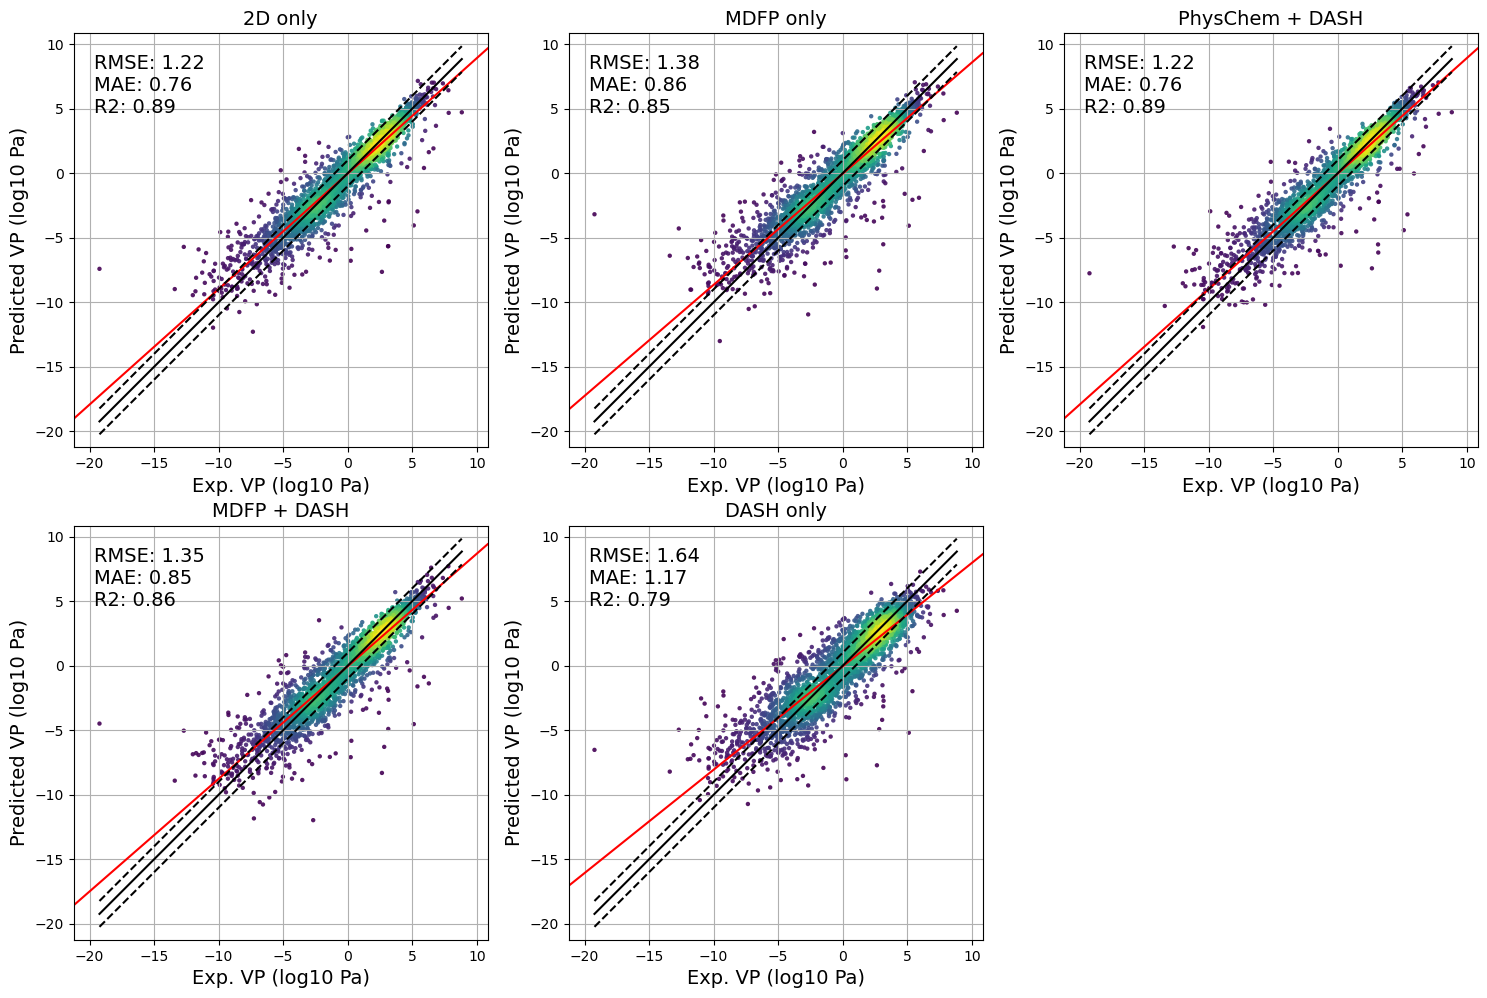

In [43]:
density_plot_multiple(reals=[real_2d_only,real_mdfp_only, real_physchem_plus_dash, real_mdfp_plus_dash, real_dash_only],
                      predictions=[prediction_2d_only,prediction_mdfp_only, prediction_physchem_plus_dash, prediction_mdfp_plus_dash, prediction_dash_only],
                      titles=['2D only','MDFP only','PhysChem + DASH','MDFP + DASH','DASH only'])
